In [2]:
import pandas as pd
import torch
from sklearn.neighbors import NearestNeighbors

# Load your final dataframe
df = pd.read_csv("final_df.csv")  # Replace with actual path

# Define feature groups
facility_types = ["clinic", "hospital", "pharmacy", "nursing_home", "social_facility"]

socio_columns = [
    "Total_Population", "Median_Household_Income", "Uninsured_Rate",
    "Rent_as_Income_Percentage", "Limited_English_Proficiency_Rate",
    "No_Vehicle_Rate", "No_Internet_Rate"
]

health_columns = [col for col in df.columns if "_CrudePrev" in col]
distance_columns = [col for col in df.columns if col.startswith("road_dist_to_")]

# Combine all features into a single matrix
feature_cols = socio_columns + health_columns + distance_columns
features = df[feature_cols].fillna(0).values
x = torch.tensor(features, dtype=torch.float)


In [4]:
!pip install umap-learn hdbscan matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 60.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 17.4 MB/s eta 0:00:00


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from torch_geometric.data import Data
from torch_geometric.nn import GAE, GCNConv
import pandas as pd
import torch
import torch.nn as nn
import torch_geometric
import numpy as np

# Load dataset
df = pd.read_csv("final_df.csv")

# Step 1: Define feature columns
sociodemographic_columns = [
    "Total_Population", "Median_Household_Income", "Uninsured_Rate",
    "Rent_as_Income_Percentage", "Limited_English_Proficiency_Rate",
    "No_Vehicle_Rate", "No_Internet_Rate"
]

health_columns = [col for col in df.columns if "_CrudePrev" in col]
distance_columns = [col for col in df.columns if col.startswith("haversine_dist_to_")]
feature_cols = sociodemographic_columns + health_columns + distance_columns

# Step 2: Normalize features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df[feature_cols].fillna(0))
x = torch.tensor(x_scaled, dtype=torch.float)

# Step 3: Build edge index using KNN
coords = df[['lat', 'lon']].values
knn = NearestNeighbors(n_neighbors=5)
knn.fit(coords)
edges = knn.kneighbors_graph(coords, mode='connectivity').tocoo()
edge_index = torch.tensor([edges.row, edges.col], dtype=torch.long)

# Step 4: Create graph data
data = Data(x=x, edge_index=edge_index)

# Step 5: Define GCN Encoder
class ImprovedGCNEncoder(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.5):
        super(ImprovedGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 128)  # Increased channels
        self.conv2 = GCNConv(128, 64)  # Added an extra layer
        self.conv3 = GCNConv(64, out_channels)  # Final layer
        
        self.dropout = dropout
        self.batch_norm1 = nn.BatchNorm1d(128)  # Batch normalization after each conv layer
        self.batch_norm2 = nn.BatchNorm1d(64)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.batch_norm1(x)
        x = torch.dropout(x, p=self.dropout, train=self.training)
        
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.batch_norm2(x)
        x = torch.dropout(x, p=self.dropout, train=self.training)
        
        return self.conv3(x, edge_index)  # Final layer without batch normalization


# Step 6: Train GAE
# Change from GCNEncoder to ImprovedGCNEncoder
model = GAE(ImprovedGCNEncoder(x.shape[1], 32))  # 32 = embedding size
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=5e-4)  # L2 regularization with weight_decay
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0

    def should_stop(self, loss):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
            return False
        elif self.counter >= self.patience:
            return True
        else:
            self.counter += 1
            return False
# Instantiate early stopping
early_stopping = EarlyStopping(patience=10, min_delta=0.01)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    z = model.encode(x, edge_index)
    loss = model.recon_loss(z, edge_index)
    
    loss.backward()
    optimizer.step()
    
    # Check for early stopping
    if early_stopping.should_stop(loss.item()):
        print(f"Early stopping at epoch {epoch}")
        break

    if epoch % 20 == 0:
        print(f"Epoch {epoch} — Loss: {loss.item():.4f}")


/tmp/ipykernel_905/3545540665.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  edge_index = torch.tensor([edges.row, edges.col], dtype=torch.long)


Epoch 0 — Loss: 3.8217
Epoch 20 — Loss: 1.0193
Epoch 40 — Loss: 0.9503
Epoch 60 — Loss: 0.9183
Early stopping at epoch 77


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


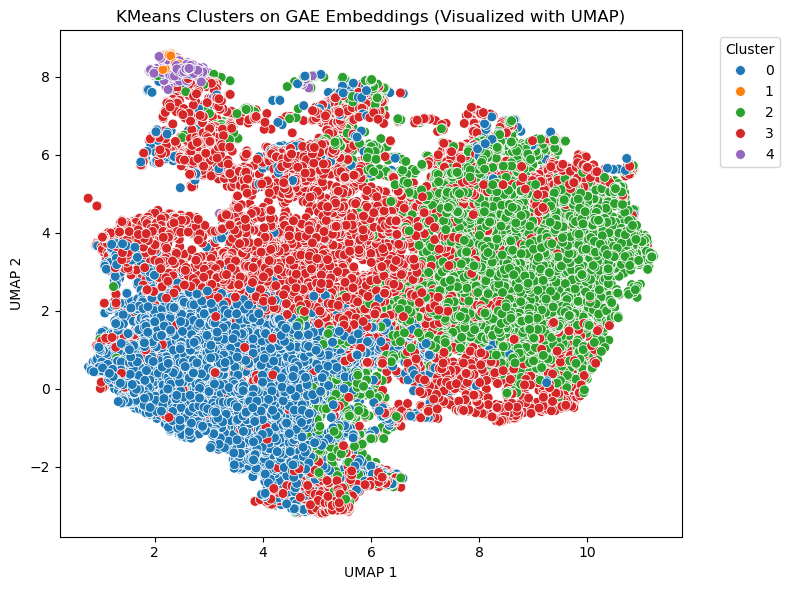

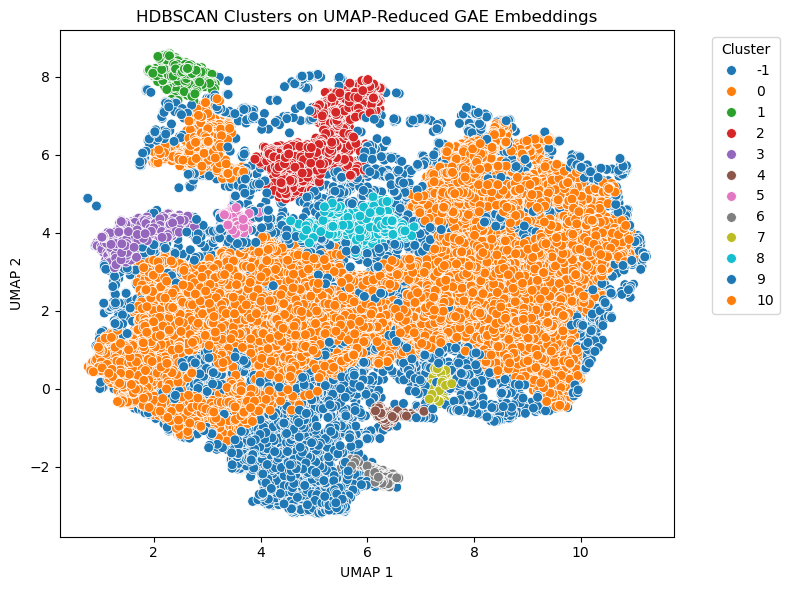

In [8]:
import umap
import hdbscan
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# If your embeddings are still in GPU, move to CPU
z_cpu = z.detach().cpu().numpy()

# Step 1: UMAP reduction to 2D for visualization
umap_2d = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
z_umap_2d = umap_2d.fit_transform(z_cpu)

# Step 2: KMeans clustering on raw embeddings
kmeans = KMeans(n_clusters=5, random_state=42)
df["kmeans_cluster"] = kmeans.fit_predict(z_cpu)

# Step 3: HDBSCAN clustering on UMAP-reduced embeddings
hdbscan_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=100,  # Try higher values like 30, 50, 100
    min_samples=30,        # Optional: increase to make it stricter
    prediction_data=True
)
df["hdbscan_cluster"] = hdbscan_clusterer.fit_predict(z_umap_2d)

# Step 4: Visualization
def plot_clusters(embeddings_2d, labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=embeddings_2d[:, 0], y=embeddings_2d[:, 1],
        hue=labels, palette="tab10", s=50, legend="full"
    )
    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plotting results
plot_clusters(z_umap_2d, df["kmeans_cluster"], "KMeans Clusters on GAE Embeddings (Visualized with UMAP)")
plot_clusters(z_umap_2d, df["hdbscan_cluster"], "HDBSCAN Clusters on UMAP-Reduced GAE Embeddings")


In [12]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import hdbscan
# import umap
# import numpy as np

# # Assuming your embeddings (z) from GAE are in the variable `z`
# # Perform UMAP to reduce the dimensionality to 2D
# umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
# z_umap_2d = umap_model.fit_transform(z.detach().numpy())  # or use your z tensor

# # Perform HDBSCAN clustering on the UMAP embeddings
# hdb = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=5)
# hdb_labels = hdb.fit_predict(z_umap_2d)

# # Now we have the cluster labels from HDBSCAN
# # -1 will be noise points

# # Create a color palette for the clusters
# palette = sns.color_palette('tab20', n_colors=len(set(hdb_labels)))

# # Plotting the clusters
# plt.figure(figsize=(10, 7))

# # Loop through each unique cluster label
# for cluster_id in set(hdb_labels):
#     # Use gray color for noise points (-1)
#     color = 'lightgray' if cluster_id == -1 else palette[cluster_id % len(palette)]
#     # Mask for points in the current cluster
#     mask = hdb_labels == cluster_id
#     # Plot points for each cluster
#     plt.scatter(z_umap_2d[mask, 0], z_umap_2d[mask, 1], s=20, c=[color], label=str(cluster_id), alpha=0.7)

# plt.legend(title='Cluster ID')
# plt.title("HDBSCAN Clustering with Noise")
# plt.xlabel("UMAP 1")
# plt.ylabel("UMAP 2")
# plt.tight_layout()
# plt.show()


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


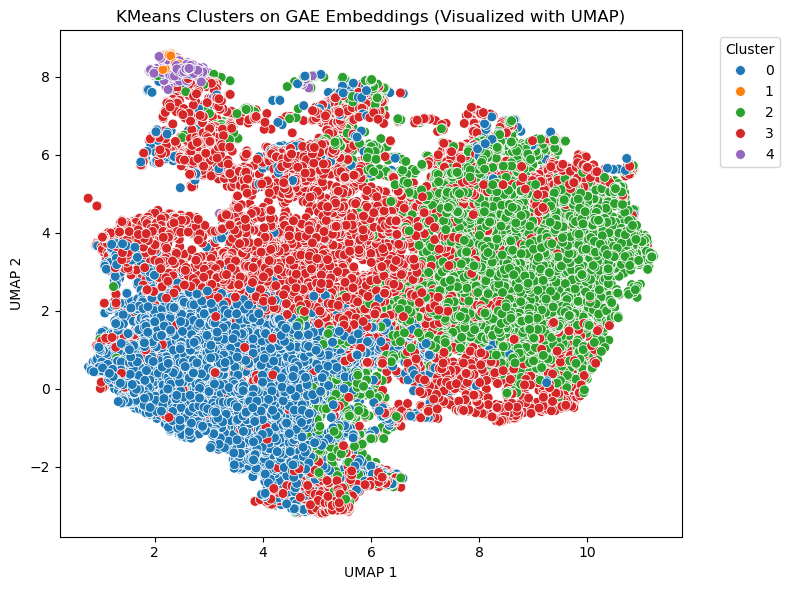

In [13]:
# KMeans_Clustering.ipynb
import umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming embeddings z are loaded as a tensor from your model
z_cpu = z.detach().cpu().numpy()  # If you're using GPU

# Step 1: UMAP reduction to 2D for visualization
umap_2d = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
z_umap_2d = umap_2d.fit_transform(z_cpu)

# Step 2: KMeans clustering on raw embeddings
kmeans = KMeans(n_clusters=5, random_state=42)
df["kmeans_cluster"] = kmeans.fit_predict(z_cpu)

# Step 3: Visualization for KMeans
def plot_clusters(embeddings_2d, labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=embeddings_2d[:, 0], y=embeddings_2d[:, 1],
        hue=labels, palette="tab10", s=50, legend="full"
    )
    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plotting KMeans results
plot_clusters(z_umap_2d, df["kmeans_cluster"], "KMeans Clusters on GAE Embeddings (Visualized with UMAP)")


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


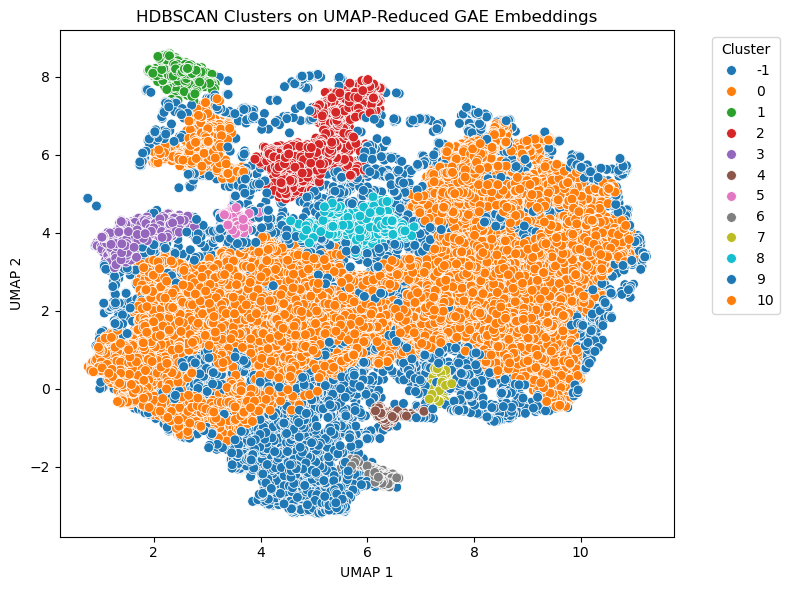

In [14]:
# HDBSCAN_Clustering.ipynb
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming embeddings z are loaded as a tensor from your model
z_cpu = z.detach().cpu().numpy()  # If you're using GPU

# Step 1: UMAP reduction to 2D for visualization
umap_2d = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
z_umap_2d = umap_2d.fit_transform(z_cpu)

# Step 2: HDBSCAN clustering on UMAP-reduced embeddings
hdbscan_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=100,  # Try higher values like 30, 50, 100
    min_samples=30,        # Optional: increase to make it stricter
    prediction_data=True
)
df["hdbscan_cluster"] = hdbscan_clusterer.fit_predict(z_umap_2d)

# Step 3: Visualization for HDBSCAN
def plot_clusters(embeddings_2d, labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=embeddings_2d[:, 0], y=embeddings_2d[:, 1],
        hue=labels, palette="tab10", s=50, legend="full"
    )
    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plotting HDBSCAN results
plot_clusters(z_umap_2d, df["hdbscan_cluster"], "HDBSCAN Clusters on UMAP-Reduced GAE Embeddings")


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


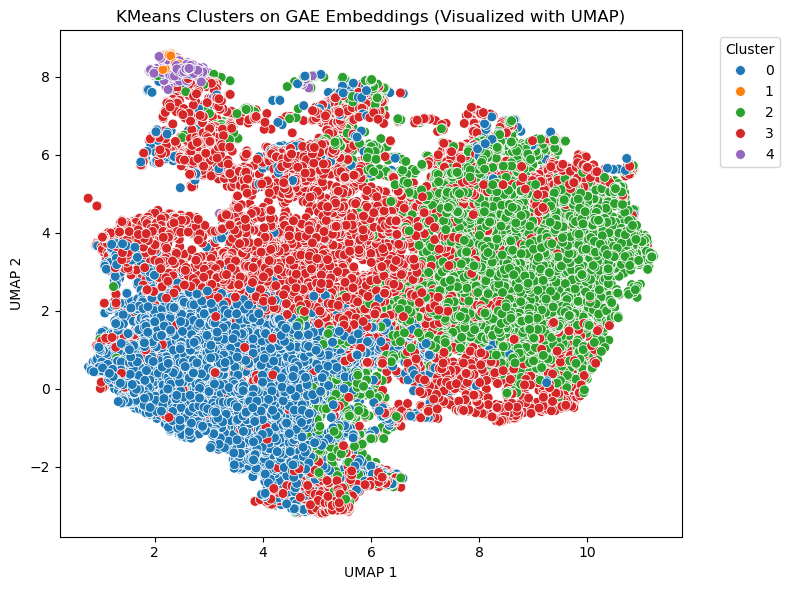

In [15]:
# KMeans_Clustering.ipynb
import umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming embeddings z are loaded as a tensor from your model
z_cpu = z.detach().cpu().numpy()  # If you're using GPU

# Step 1: UMAP reduction to 2D for visualization
umap_2d = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
z_umap_2d = umap_2d.fit_transform(z_cpu)

# Step 2: KMeans clustering on raw embeddings
kmeans = KMeans(n_clusters=5, random_state=42)
df["kmeans_cluster"] = kmeans.fit_predict(z_cpu)

# Step 3: Visualization for KMeans
def plot_clusters(embeddings_2d, labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=embeddings_2d[:, 0], y=embeddings_2d[:, 1],
        hue=labels, palette="tab10", s=50, legend="full"
    )
    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plotting KMeans results
plot_clusters(z_umap_2d, df["kmeans_cluster"], "KMeans Clusters on GAE Embeddings (Visualized with UMAP)")


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


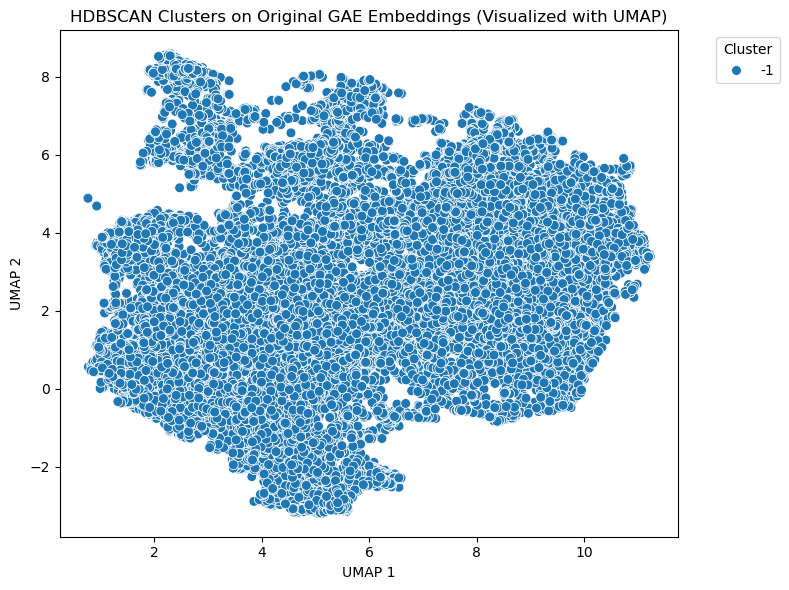

In [16]:
# HDBSCAN_Clustering.ipynb

import umap
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch

# Load your DataFrame (assuming you already have the embeddings `z`)
df = pd.read_csv("final_df.csv")

# Make sure GAE embeddings `z` are already generated and available
# If z is a torch tensor and on GPU, move to CPU
z_cpu = z.detach().cpu().numpy()

# Step 1: HDBSCAN clustering on original GAE embeddings
hdbscan_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=100,  # Adjust based on your density preference
    min_samples=30,
    prediction_data=True
)
df["hdbscan_cluster"] = hdbscan_clusterer.fit_predict(z_cpu)

# Step 2: UMAP reduction to 2D for visualization only
umap_2d = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
z_umap_2d = umap_2d.fit_transform(z_cpu)

# Step 3: Visualization
def plot_clusters(embeddings_2d, labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=embeddings_2d[:, 0], y=embeddings_2d[:, 1],
        hue=labels, palette="tab10", s=50, legend="full"
    )
    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Step 4: Plotting
plot_clusters(z_umap_2d, df["hdbscan_cluster"], "HDBSCAN Clusters on Original GAE Embeddings (Visualized with UMAP)")


In [ ]:
import umap
import hdbscan
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import pandas as pd

# Function to evaluate clustering results
def evaluate_clustering(data, labels, metric_name="silhouette"):
    # Ignore noise points (labeled as -1) for evaluation
    if -1 in set(labels):
        valid_indices = labels != -1
        if sum(valid_indices) <= 1:  # If only one valid point or none
            return -1  # Return a poor score
        eval_data = data[valid_indices]
        eval_labels = labels[valid_indices]
    else:
        eval_data = data
        eval_labels = labels
    
    # Check if we have at least 2 valid clusters
    if len(set(eval_labels)) < 2:
        return -1
    
    if metric_name == "silhouette":
        return silhouette_score(eval_data, eval_labels)
    elif metric_name == "calinski_harabasz":
        return calinski_harabasz_score(eval_data, eval_labels)
    elif metric_name == "davies_bouldin":
        return davies_bouldin_score(eval_data, eval_labels)
    else:
        raise ValueError(f"Unknown metric: {metric_name}")

umap_params = {
    'n_neighbors': [5, 15, 30, 50],
    'min_dist': [0.0, 0.1, 0.5],
    'n_components': [2, 10, 30]  # Try different dimensions
}

umap_projections = {}

print("Generating UMAP projections with different parameters...")
for n_neighbors in umap_params['n_neighbors']:
    for min_dist in umap_params['min_dist']:
        for n_components in umap_params['n_components']:
            key = f"nn{n_neighbors}_md{min_dist}_nc{n_components}"
            umap_reducer = umap.UMAP(
                n_neighbors=n_neighbors,
                min_dist=min_dist,
                n_components=n_components,
                random_state=42
            )
            umap_projections[key] = umap_reducer.fit_transform(z_cpu)
            print(f"Created UMAP projection: {key}")

kmeans_params = {
    'n_clusters': [3, 5, 7, 10, 15]
}

kmeans_results = []
print("\nRunning KMeans grid search...")
for projection_key, projection_data in umap_projections.items():
    for n_clusters in kmeans_params['n_clusters']:
        print(f"Running KMeans with {n_clusters} clusters on projection {projection_key}")
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(projection_data)
        
        sil_score = evaluate_clustering(projection_data, cluster_labels, "silhouette")
        ch_score = evaluate_clustering(projection_data, cluster_labels, "calinski_harabasz")
        db_score = evaluate_clustering(projection_data, cluster_labels, "davies_bouldin")
        
        kmeans_results.append({
            'method': 'KMeans',
            'projection': projection_key,
            'n_clusters': n_clusters,
            'silhouette': sil_score,
            'calinski_harabasz': ch_score,
            'davies_bouldin': db_score,  # Lower is better for DB index
            'unique_clusters': len(set(cluster_labels))
        })

hdbscan_params = {
    'min_cluster_size': [50, 100, 200],
    'min_samples': [5, 15, 30],
    'cluster_selection_epsilon': [0.0, 0.5, 1.0]
}

hdbscan_results = []
print("\nRunning HDBSCAN grid search...")
for projection_key, projection_data in umap_projections.items():
    for min_cluster_size in hdbscan_params['min_cluster_size']:
        for min_samples in hdbscan_params['min_samples']:
            for cluster_selection_epsilon in hdbscan_params['cluster_selection_epsilon']:
                print(f"Running HDBSCAN with mcs={min_cluster_size}, ms={min_samples}, eps={cluster_selection_epsilon} on projection {projection_key}")
                
                clusterer = hdbscan.HDBSCAN(
                    min_cluster_size=min_cluster_size,
                    min_samples=min_samples,
                    cluster_selection_epsilon=cluster_selection_epsilon,
                    prediction_data=True
                )
                
                try:
                    cluster_labels = clusterer.fit_predict(projection_data)
                    
                    # Evaluate (only if we have at least one non-noise cluster)
                    if len(set(cluster_labels)) > 1:
                        sil_score = evaluate_clustering(projection_data, cluster_labels, "silhouette")
                        ch_score = evaluate_clustering(projection_data, cluster_labels, "calinski_harabasz")
                        db_score = evaluate_clustering(projection_data, cluster_labels, "davies_bouldin")
                    else:
                        sil_score = ch_score = -1
                        db_score = float('inf')
                    
                    hdbscan_results.append({
                        'method': 'HDBSCAN',
                        'projection': projection_key,
                        'min_cluster_size': min_cluster_size,
                        'min_samples': min_samples,
                        'cluster_selection_epsilon': cluster_selection_epsilon,
                        'silhouette': sil_score,
                        'calinski_harabasz': ch_score,
                        'davies_bouldin': db_score,
                        'noise_points': sum(cluster_labels == -1),
                        'unique_clusters': len(set([c for c in cluster_labels if c != -1]))
                    })
                except Exception as e:
                    print(f"Error with HDBSCAN configuration: {e}")

# Combine results
all_results = pd.DataFrame(kmeans_results + hdbscan_results)

# Find best configurations by different metrics
best_silhouette = all_results.loc[all_results['silhouette'].idxmax()]
best_ch = all_results.loc[all_results['calinski_harabasz'].idxmax()]
best_db = all_results.loc[all_results['davies_bouldin'].idxmin()]  # For DB index, lower is better

print("\nBest configuration by Silhouette score:")
print(best_silhouette)

print("\nBest configuration by Calinski-Harabasz score:")
print(best_ch)

print("\nBest configuration by Davies-Bouldin score:")
print(best_db)

umap_2d_vis = {}
for key, projection in umap_projections.items():
    if 'nc2' in key:  # Already 2D
        umap_2d_vis[key] = projection
    else:
        # Create a new 2D projection for visualization only
        mapper = umap.UMAP(n_components=2, random_state=42)
        umap_2d_vis[key] = mapper.fit_transform(projection)

# Function to apply clustering with best params and visualize
def visualize_best_clustering(best_config):
    projection_key = best_config['projection']
    method = best_config['method']
    projection_data = umap_projections[projection_key]
    
    if method == 'KMeans':
        clusterer = KMeans(n_clusters=int(best_config['n_clusters']), random_state=42)
        labels = clusterer.fit_predict(projection_data)
        title = f"Best KMeans: n_clusters={int(best_config['n_clusters'])}, {projection_key}"
    else:  # HDBSCAN
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=int(best_config['min_cluster_size']),
            min_samples=int(best_config['min_samples']),
            cluster_selection_epsilon=float(best_config['cluster_selection_epsilon']),
            prediction_data=True
        )
        labels = clusterer.fit_predict(projection_data)
        title = f"Best HDBSCAN: mcs={int(best_config['min_cluster_size'])}, ms={int(best_config['min_samples'])}, {projection_key}"
    
    # Visualize using the 2D version
    plt.figure(figsize=(12, 8))
    
    # For HDBSCAN, mark noise points differently
    if method == 'HDBSCAN':
        # Plot noise points as gray
        mask_noise = labels == -1
        plt.scatter(
            umap_2d_vis[projection_key][mask_noise, 0], 
            umap_2d_vis[projection_key][mask_noise, 1],
            c='lightgray', s=10, label='Noise'
        )
        
        # Plot clustered points with colors
        mask_clusters = ~mask_noise
        plt.scatter(
            umap_2d_vis[projection_key][mask_clusters, 0], 
            umap_2d_vis[projection_key][mask_clusters, 1],
            c=labels[mask_clusters], cmap='tab10', s=30
        )
    else:
        plt.scatter(
            umap_2d_vis[projection_key][:, 0], 
            umap_2d_vis[projection_key][:, 1],
            c=labels, cmap='tab10', s=30
        )
    
    plt.colorbar(label='Cluster')
    plt.title(f"{title}\nScore: {best_config['silhouette']:.3f}")
    plt.tight_layout()
    plt.show()
    
    return labels

# Visualize the best configurations
print("\nVisualizing best clustering configurations:")
best_silhouette_labels = visualize_best_clustering(best_silhouette)
best_ch_labels = visualize_best_clustering(best_ch)
best_db_labels = visualize_best_clustering(best_db)

# Add the best cluster assignments back to the dataframe
if best_silhouette['method'] == 'KMeans':
    kmeans = KMeans(n_clusters=int(best_silhouette['n_clusters']), random_state=42)
    df['best_kmeans_cluster'] = kmeans.fit_predict(umap_projections[best_silhouette['projection']])
else:
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=int(best_silhouette['min_cluster_size']),
        min_samples=int(best_silhouette['min_samples']),
        cluster_selection_epsilon=float(best_silhouette['cluster_selection_epsilon']),
        prediction_data=True
    )
    df['best_hdbscan_cluster'] = clusterer.fit_predict(umap_projections[best_silhouette['projection']])

print("\nClustering complete. Best cluster assignments added to dataframe.")

Generating UMAP projections with different parameters...


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn5_md0.0_nc2


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn5_md0.0_nc10


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn5_md0.0_nc30


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn5_md0.1_nc2


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn5_md0.1_nc10


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn5_md0.1_nc30


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn5_md0.5_nc2


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn5_md0.5_nc10


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn5_md0.5_nc30


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn15_md0.0_nc2


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn15_md0.0_nc10


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn15_md0.0_nc30


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn15_md0.1_nc2


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn15_md0.1_nc10


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn15_md0.1_nc30


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn15_md0.5_nc2


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn15_md0.5_nc10


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn15_md0.5_nc30


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn30_md0.0_nc2


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn30_md0.0_nc10


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn30_md0.0_nc30


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn30_md0.1_nc2


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn30_md0.1_nc10


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn30_md0.1_nc30


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn30_md0.5_nc2


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn30_md0.5_nc10


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn30_md0.5_nc30


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn50_md0.0_nc2


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn50_md0.0_nc10


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn50_md0.0_nc30


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn50_md0.1_nc2


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn50_md0.1_nc10


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn50_md0.1_nc30


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn50_md0.5_nc2


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn50_md0.5_nc10


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Created UMAP projection: nn50_md0.5_nc30

Running KMeans grid search...
Running KMeans with 3 clusters on projection nn5_md0.0_nc2
Running KMeans with 5 clusters on projection nn5_md0.0_nc2
Running KMeans with 7 clusters on projection nn5_md0.0_nc2
Running KMeans with 10 clusters on projection nn5_md0.0_nc2
Running KMeans with 15 clusters on projection nn5_md0.0_nc2
Running KMeans with 3 clusters on projection nn5_md0.0_nc10
Running KMeans with 5 clusters on projection nn5_md0.0_nc10
Running KMeans with 7 clusters on projection nn5_md0.0_nc10
Running KMeans with 10 clusters on projection nn5_md0.0_nc10
Running KMeans with 15 clusters on projection nn5_md0.0_nc10
Running KMeans with 3 clusters on projection nn5_md0.0_nc30
Running KMeans with 5 clusters on projection nn5_md0.0_nc30
Running KMeans with 7 clusters on projection nn5_md0.0_nc30
Running KMeans with 10 clusters on projection nn5_md0.0_nc30
Running KMeans with 15 clusters on projection nn5_md0.0_nc30
Running KMeans with 3 clust